In [1]:
import numpy as np
import pandas as pd 
import warnings
warnings.filterwarnings('ignore')
import itertools



import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from matplotlib.collections import LineCollection
from matplotlib.colors import ListedColormap, BoundaryNorm
import seaborn as sns
sns.set_theme(style="white")
%matplotlib inline


from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from sklearn.model_selection import GridSearchCV
from statsmodels.tsa.arima_model import ARIMA
import statsmodels.api as sm
sm.tsa.statespace.SARIMAX
from statsmodels.tsa.arima_model import ARMA
import pmdarima as pm
from sklearn import metrics
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

In [2]:
weekly = pd.read_csv('co2_weekly_mlo.csv')

In [3]:
weekly.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2441 entries, 0 to 2440
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   year                 2441 non-null   int64  
 1   month                2441 non-null   int64  
 2   day                  2441 non-null   int64  
 3   decimal              2441 non-null   float64
 4   average              2441 non-null   float64
 5   ndays                2441 non-null   int64  
 6   1 year ago           2441 non-null   float64
 7   10 years ago         2441 non-null   float64
 8   increase since 1800  2441 non-null   float64
dtypes: float64(5), int64(4)
memory usage: 171.8 KB


In [4]:
weekly.isna().sum()

year                   0
month                  0
day                    0
decimal                0
average                0
ndays                  0
1 year ago             0
10 years ago           0
increase since 1800    0
dtype: int64

In [5]:
#Make inital changes to data including: 
weekly['Date'] = pd.to_datetime(weekly[['year', 'month', 'day']])  #Creating a data column
weekly['average'] = weekly['average'].abs()  #Making all numbers in average column positive by changing them to absolute values
weekly['increase since 1800'] = weekly['increase since 1800'].abs()  #Making all numbers in increase since 1800 column positive by changing them to absolute values
weekly.drop(columns = ['decimal', '1 year ago', '10 years ago'], inplace = True) #Dropping unneeded columns 

In [6]:
inc1975=weekly.loc[[71, 73], 'increase since 1800'].mean() 
weekly.loc[[72, 81, 82, 83, 84], 'increase since 1800'] = inc1975 

inc1976=weekly.loc[[109,111], 'increase since 1800'].mean() 
weekly.loc[[110], 'increase since 1800'] = inc1976 

inc1982=weekly.loc[[411, 414], 'increase since 1800'].mean() 
weekly.loc[[409, 412, 413], 'increase since 1800'] = inc1982 

inc1983=weekly.loc[[480, 482], 'increase since 1800'].mean() 
weekly.loc[[481], 'increase since 1800'] = inc1983

inc1984=weekly.loc[[514, 519], 'increase since 1800'].mean() 
weekly.loc[[515, 516, 517, 518], 'increase since 1800'] = inc1984

inc2005=weekly.loc[[1638, 1640], 'increase since 1800'].mean() 
weekly.loc[[1639], 'increase since 1800'] = inc2005 

inc2008=weekly.loc[[1779, 1783], 'increase since 1800'].mean() 
weekly.loc[[1780, 1781, 1782], 'increase since 1800'] = inc2008

In [7]:
#Replace the values with the average for the rows above and below the value(s) that need to changed for the average column
ppm1975=weekly.loc[[71, 85], 'average'].mean() 
weekly.loc[[72, 81, 82, 83, 84], 'average'] = ppm1975  

ppm1976=weekly.loc[[109, 111], 'average'].mean() 
weekly.loc[[110], 'average'] = ppm1976  

ppm1982=weekly.loc[[408, 414], 'average'].mean() 
weekly.loc[[409, 412, 413], 'average'] = ppm1982

ppm1983=weekly.loc[[480, 482], 'average'].mean() 
weekly.loc[[481], 'average'] = ppm1983

ppm1984=weekly.loc[[514, 519], 'average'].mean() 
weekly.loc[[515, 516, 517, 518], 'average'] = ppm1984

ppm2005=weekly.loc[[1638, 1640], 'average'].mean() 
weekly.loc[[1639], 'average'] = ppm2005

ppm2008=weekly.loc[[1779, 1783], 'average'].mean() 
weekly.loc[[1780, 1781, 1782], 'average'] = ppm2008

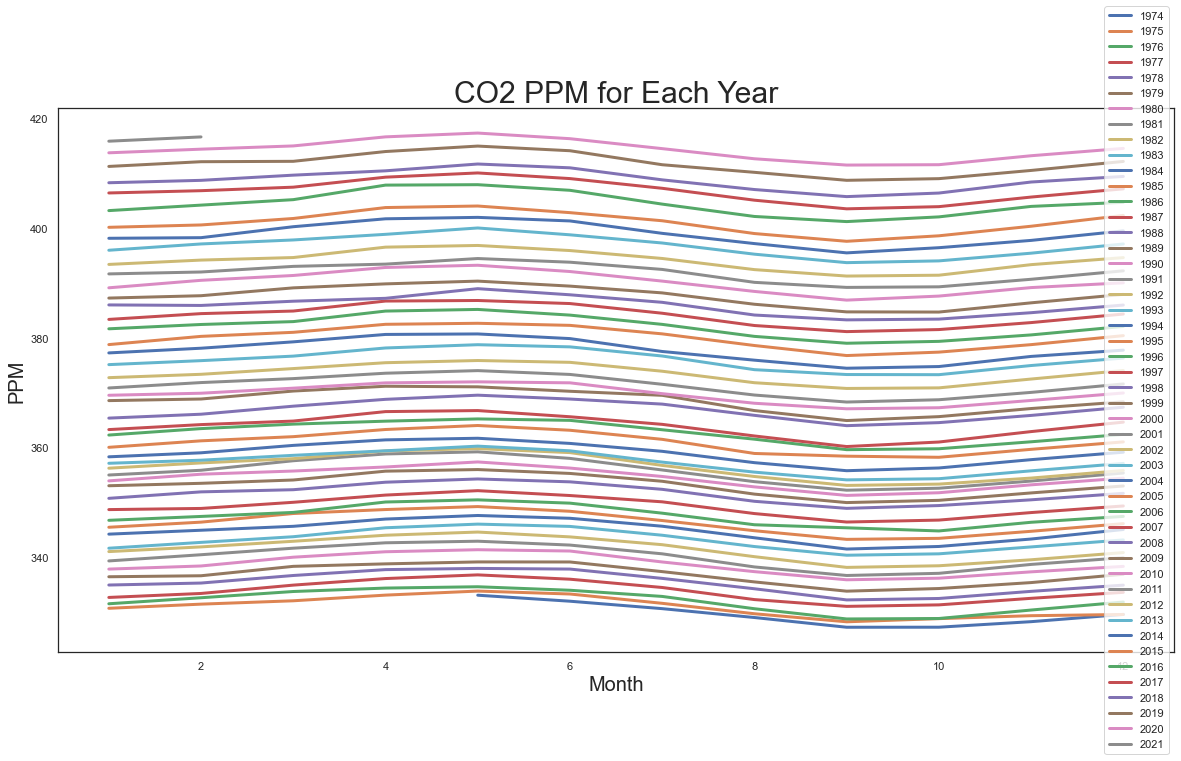

In [8]:
#Graph the average column to confirm outliers hav e been addressed
season = weekly
season['Date'] = weekly.Date
season['year'] = weekly['Date'].dt.year
season['month'] = weekly['Date'].dt.month
spivot = pd.pivot_table(season, index='month', columns = 'year', values = 'average', aggfunc=np.mean)
spivot.plot(figsize=(20,10), linewidth=3)
plt.legend(loc = 'right')
plt.title('CO2 PPM for Each Year', fontsize = 30)
plt.ylabel('PPM', fontsize = 20) 
plt.xlabel('Month', fontsize = 20)
plt.show()

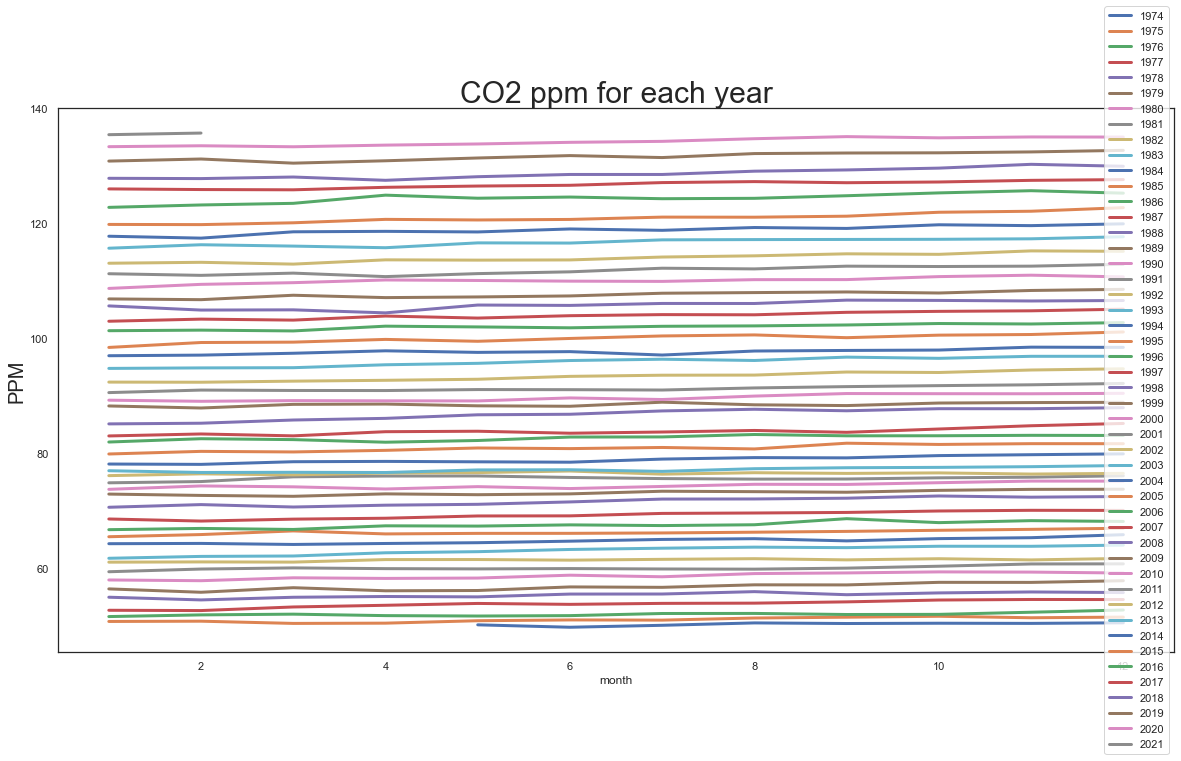

In [9]:
season = weekly
season['Date'] = weekly.Date
season['year'] = weekly['Date'].dt.year
season['month'] = weekly['Date'].dt.month
spivot = pd.pivot_table(season, index='month', columns = 'year', values = 'increase since 1800', aggfunc=np.mean)
spivot.plot(figsize=(20,10), linewidth=3)
plt.legend(loc = 'right')
plt.title('CO2 ppm for each year', fontsize = 30)
plt.ylabel('PPM', fontsize = 20)
plt.show()

In [10]:
0 % 8

0

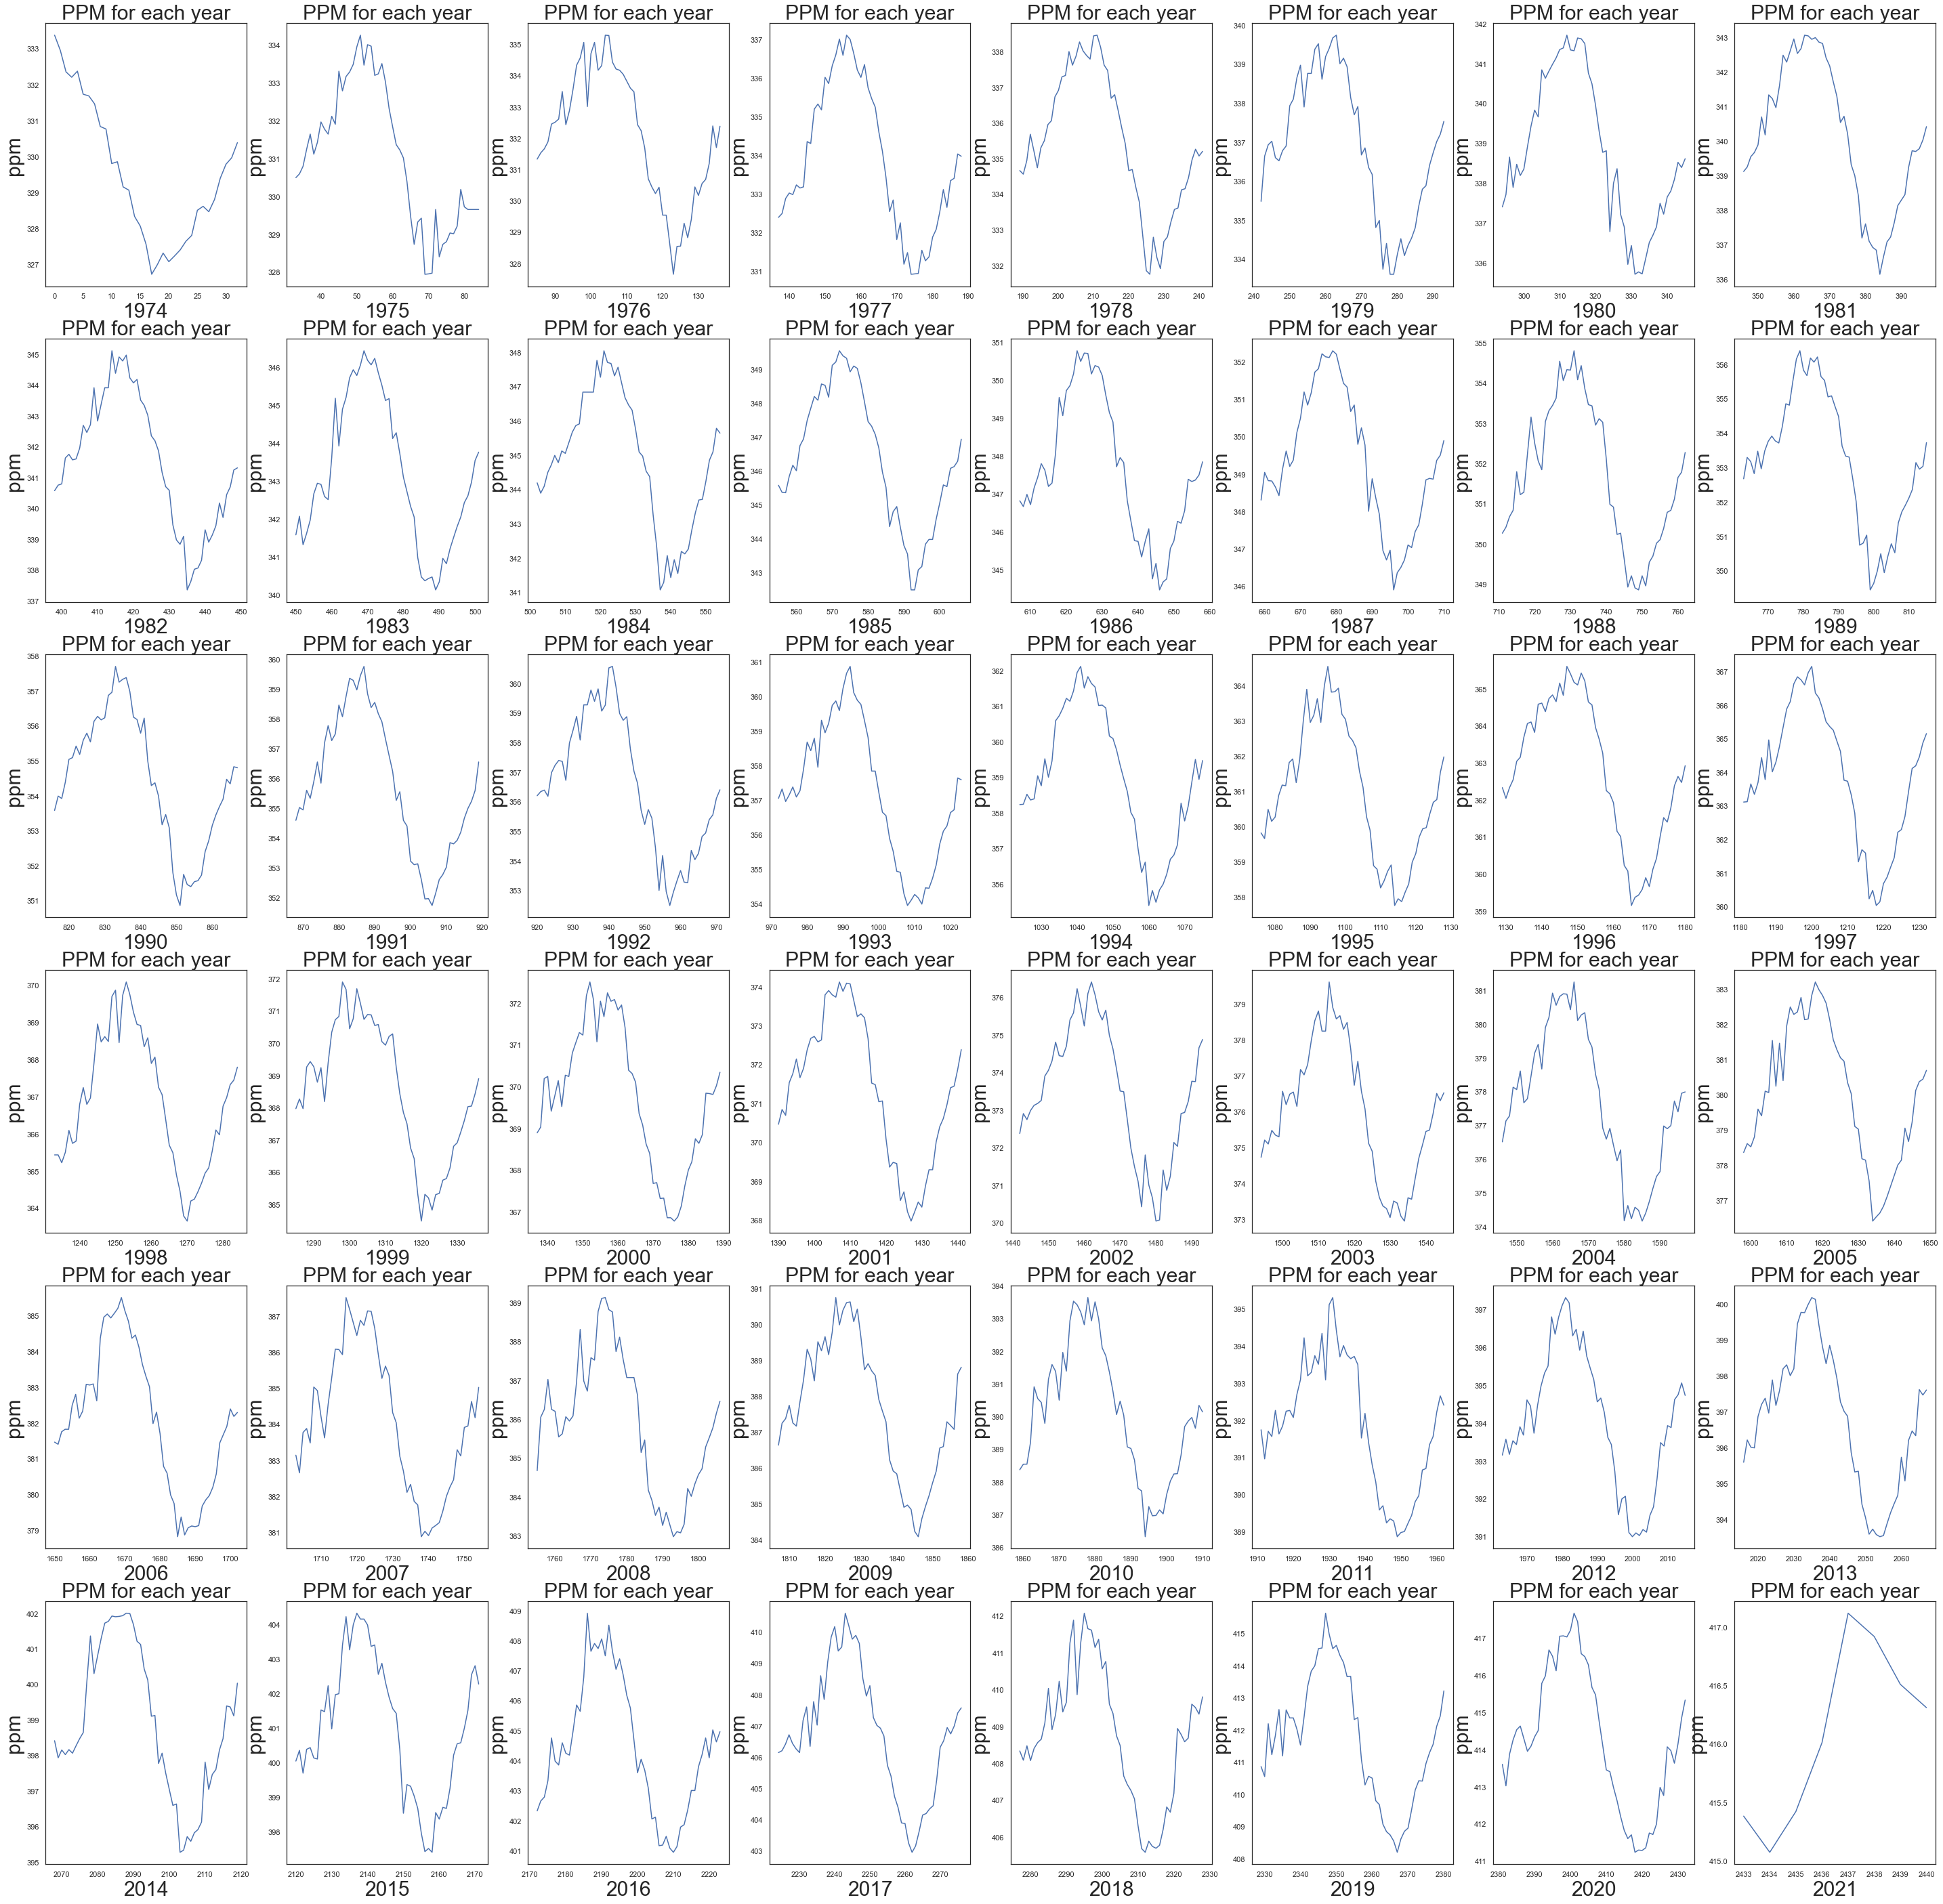

In [11]:
years = weekly['year'].unique()

fig, ax = plt.subplots(nrows = 6, ncols = 8, figsize = (50,50))

for index, year in enumerate(years):
    i = index // 8 
    j = index % 8
    current_ax = ax[i][j]
    weekly.loc[weekly['year']  == year, 'average'].plot(ax = current_ax)
    current_ax.set_title('PPM for each year', fontsize = 30)
    current_ax.set_xlabel(year, fontsize = 30)
    current_ax.set_ylabel('ppm', fontsize = 30)

In [12]:
# using groupby function with aggregation 
# to get mean, min and max values 
result = weekly.groupby('month').agg({'average': ['mean', 'min', 'max']}) 
print("Mean, min, and max values of Top Speed grouped by Vehicle Type") 
print(result)

Mean, min, and max values of Top Speed grouped by Vehicle Type
          average                
             mean     min     max
month                            
1      368.633990  330.49  417.12
2      368.984868  331.11  416.92
3      369.526863  331.64  415.98
4      370.655127  332.78  417.05
5      370.649757  332.95  417.67
6      369.430594  331.68  416.58
7      367.978846  329.80  415.47
8      365.720361  328.33  413.40
9      364.529950  326.72  411.70
10     364.534589  327.07  411.75
11     366.223218  327.80  414.07
12     367.647933  328.80  415.33


In [13]:
top_month_avg = weekly.groupby(['year', 'month', 'average']).max()
top_month_avg

day  ndays  increase since 1800       Date
year month average                                            
1974 5     332.95    26      6                50.06 1974-05-26
           333.37    19      5                50.40 1974-05-19
     6     331.68    30      6                50.02 1974-06-30
           331.73    23      5                49.72 1974-06-23
           332.20     9      7                49.65 1974-06-09
...                 ...    ...                  ...        ...
2021 1     416.01    24      7               135.50 2021-01-24
           417.12    31      7               136.49 2021-01-31
     2     416.31    21      7               135.36 2021-02-21
           416.51    14      7               135.67 2021-02-14
           416.92     7      7               136.18 2021-02-07

[2412 rows x 4 columns]

In [14]:
month_high = weekly.loc[weekly.groupby("year")["average"].idxmax()]
month_high

,year,month,day,average,ndays,increase since 1800,Date
0,1974,5,19,333.37,5,50.40,1974-05-19
51,1975,5,11,334.25,6,51.24,1975-05-11
104,1976,5,16,335.29,4,52.29,1976-05-16
156,1977,5,15,337.10,4,54.13,1977-05-15
211,1978,6,4,338.46,2,55.76,1978-06-04
263,1979,6,3,339.74,6,56.98,1979-06-03
312,1980,5,11,341.71,6,58.59,1980-05-11
363,1981,5,3,343.07,6,59.99,1981-05-03
414,1982,4,25,345.11,3,62.14,1982-04-25
469,1983,5,15,346.43,7,63.21,1983-05-15


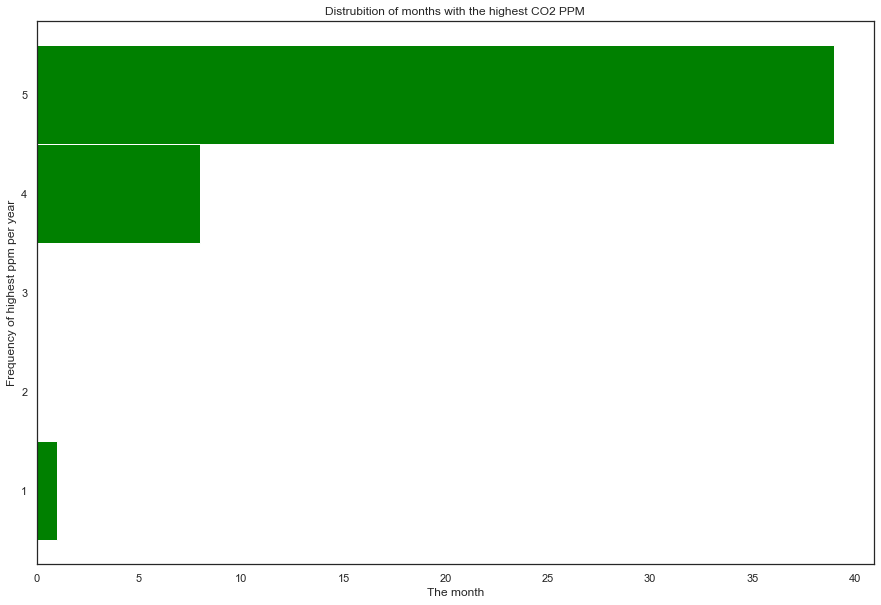

In [15]:
fig = plt.figure(figsize = (15, 10))
plt.hist(month_high.month, bins = 5, align = 'left', orientation='horizontal', color='green')
plt.title('Distrubition of months with the highest CO2 PPM')
plt.xlabel('The month')
plt.ylabel('Frequency of highest ppm per year')
plt.show();

In [16]:
weekly

,year,month,day,average,ndays,increase since 1800,Date
0,1974,5,19,333.37,5,50.40,1974-05-19
1,1974,5,26,332.95,6,50.06,1974-05-26
2,1974,6,2,332.35,5,49.60,1974-06-02
3,1974,6,9,332.20,7,49.65,1974-06-09
4,1974,6,16,332.37,7,50.06,1974-06-16
...,...,...,...,...,...,...,...
2436,2021,1,24,416.01,7,135.50,2021-01-24
2437,2021,1,31,417.12,7,136.49,2021-01-31
2438,2021,2,7,416.92,7,136.18,2021-02-07
2439,2021,2,14,416.51,7,135.67,2021-02-14


> In the northern fall, winter, and early spring, plants and soils give off CO2, causing levels to rise through May. The continued increase in CO2 and the seasonal cycle are the main features of what is known as the Keeling Curve. (https://scitechdaily.com/may-2020-had-the-highest-monthly-atmospheric-co2-reading-ever-recorded/#:~:text=In%20the%20northern%20fall%2C%20winter,vary%20by%20a%20small%20degree.)

In [17]:
upper = 400
lower = 360

supper = np.ma.masked_where(weekly.average < upper, weekly.average)
slower = np.ma.masked_where(weekly.average > lower, weekly.average)
smiddle = np.ma.masked_where((weekly.average < lower) | (weekly.average > upper) , weekly.average)

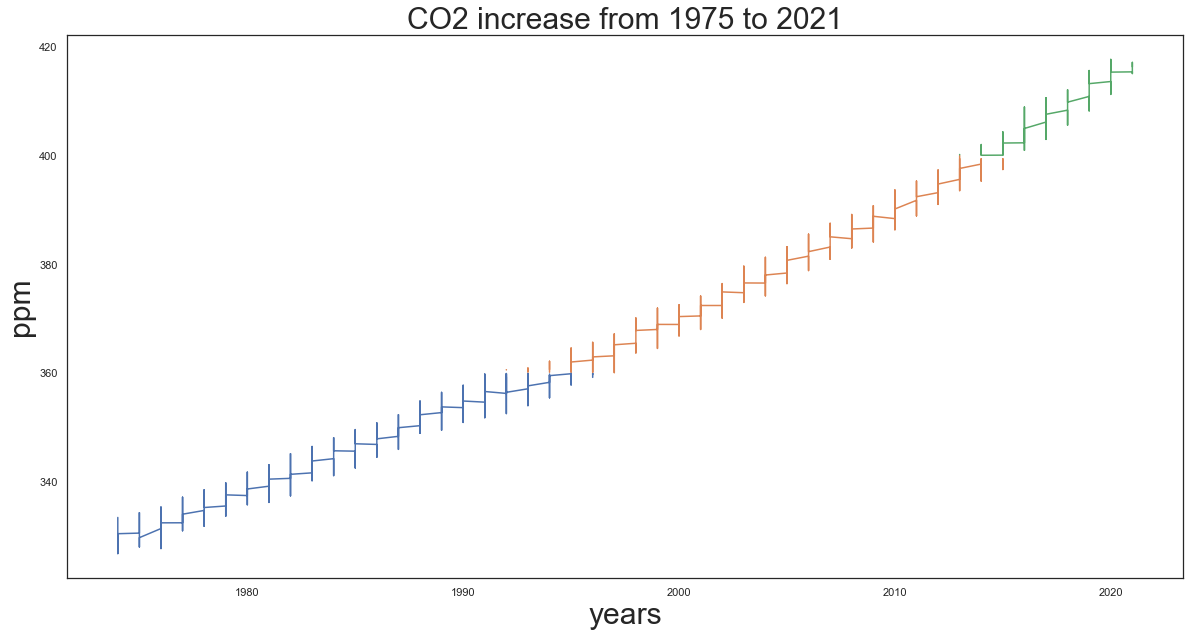

In [18]:

fig, ax= plt.subplots(figsize = (20,10))
ax.plot(weekly.year, slower, weekly.year, smiddle, weekly.year, supper);
ax.set_xlabel('years', fontsize = 30)
ax.set_ylabel('ppm', fontsize = 30)
ax.set_title('CO2 increase from 1975 to 2021', fontsize = 30)
plt.show()

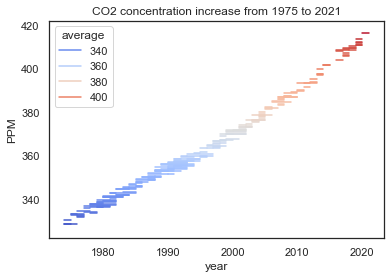

In [19]:
sns.lineplot(x = 'year', y = 'average', data = weekly, hue = 'average', palette='coolwarm')
plt.ylabel('PPM')
plt.title('CO2 concentration increase from 1975 to 2021');

In [20]:
avg_weekly = weekly.copy()
avg_weekly = avg_weekly.drop(columns = ['year', 'month', 'day', 'ndays'])

In [21]:
avg_weekly.set_index('Date', inplace = True)

In [22]:
avg_week = avg_weekly.copy()
inc_week = avg_weekly.copy()

In [23]:
avg_week = avg_week.drop(columns = ['increase since 1800'])
inc_week = inc_week.drop(columns = ['average'])

In [24]:
month_mean = avg_weekly['average'].resample('M').mean()
month_std = avg_weekly['increase since 1800'].resample('M').std()

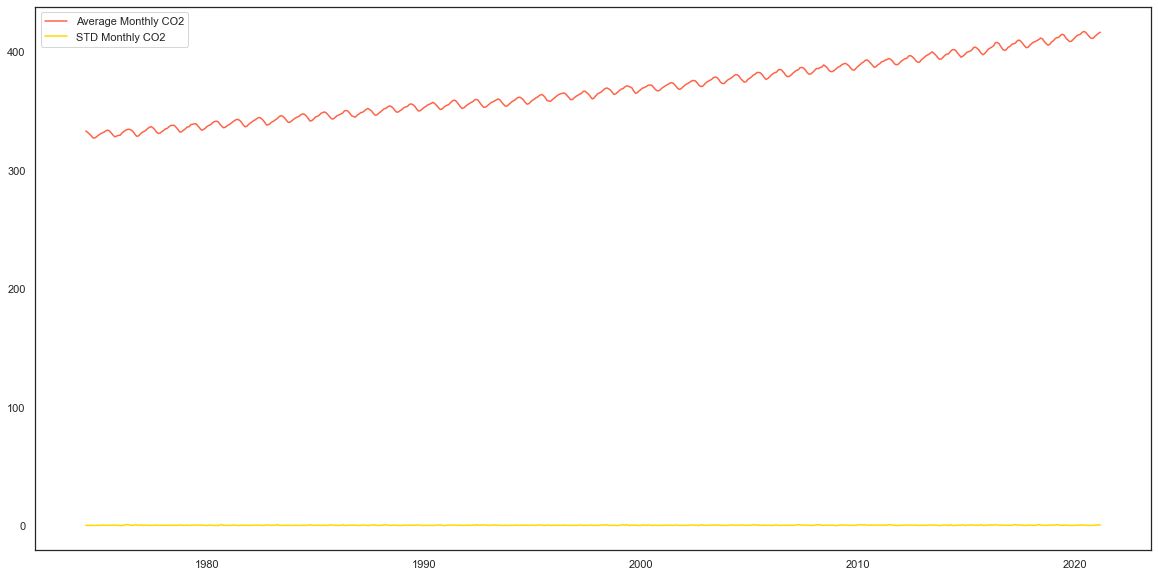

In [25]:
fig = plt.figure(figsize = (20,10))
plt.plot(month_mean, color = 'tomato', label = 'Average Monthly CO2')
plt.plot(month_std, color = 'gold', label = 'STD Monthly CO2')
plt.legend(loc = 'best')
plt.show()

<AxesSubplot:xlabel='Date'>

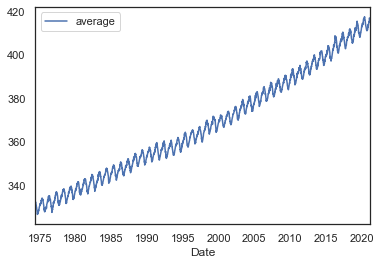

In [26]:
avg_week.plot()

In [239]:
avg_week

,average
Date,
1974-05-19,333.37
1974-05-26,332.95
1974-06-02,332.35
1974-06-09,332.20
1974-06-16,332.37
...,...
2021-01-24,416.01
2021-01-31,417.12
2021-02-07,416.92


In [27]:
from statsmodels.tsa.stattools import adfuller
test = adfuller(avg_weekly['average'][1:-1])
dfoutput = pd.Series(test[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
print(dfoutput)

Test Statistic                    0.294789
p-value                           0.977104
#Lags Used                       27.000000
Number of Observations Used    2411.000000
dtype: float64


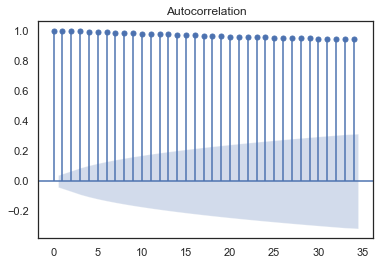

In [28]:
plot_acf(avg_weekly['average'][:-1], alpha=0.05);

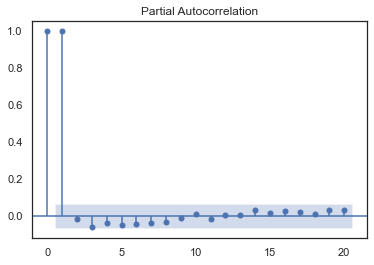

In [29]:
plot_pacf(avg_weekly['average'][:-1], alpha = 0.001, lags=20);

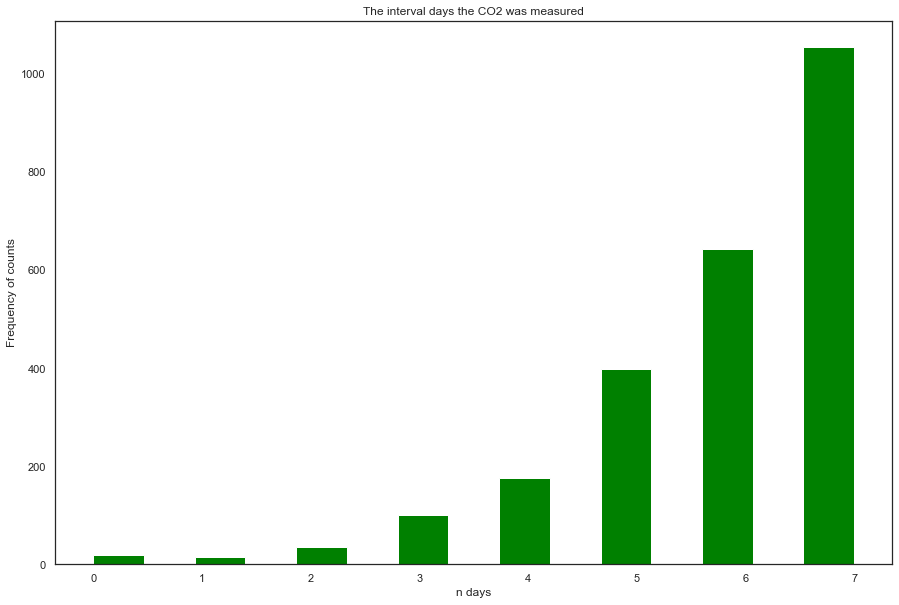

In [30]:
fig, plt.figure(figsize = (15,10))
plt.hist(weekly.ndays, bins = 15, align='mid', color = 'green')
plt.xlabel('n days')
plt.ylabel('Frequency of counts')
plt.title('The interval days the CO2 was measured')
plt.show()

In [31]:
def difference(df, interval = 7):
    diff = []
    for i in range(interval, len(df)):
        value = dataset[i] - dataset[i - interval]  
        diff.append(value)
        return Series(diff)

In [32]:
diff = weekly.average.diff()

In [33]:
diff_df = pd.DataFrame(diff)


In [34]:
diff_df = diff_df.rename(columns = {'average': 'difference'})
diff_df = diff_df.reset_index()
diff_df.dropna(inplace=True)

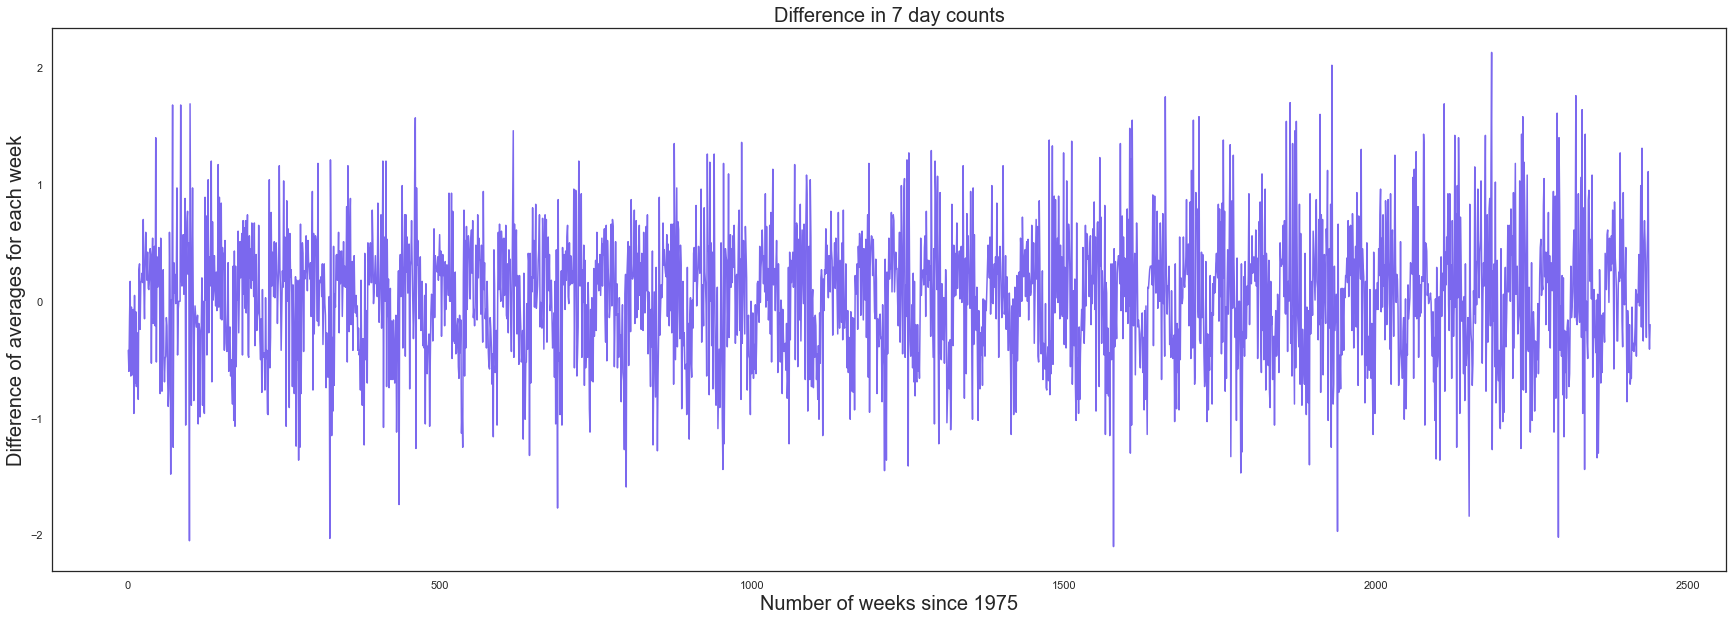

In [35]:
fig, plt.figure(figsize = (30,10))
sns.lineplot(x = 'index', y = 'difference', data = diff_df, color='mediumslateblue')
plt.xlabel('Number of weeks since 1975', fontsize = 20)
plt.title('Difference in 7 day counts', fontsize = 20)
plt.ylabel('Difference of averages for each week', fontsize = 20)
plt.show()

In [36]:
def stats_check(df, winsiz, column):
    
    
    roll_mean = df.rolling(window = winsiz, center = False).mean()
    roll_std = df.rolling(window = winsiz, center = False).std()
    
    
    dftest = adfuller(df[column])
    
    
    fig = plt.figure(figsize = (20,10))
    plt.plot(df, color = 'green', label = 'PPM ')
    plt.plot(roll_mean, color = 'red', label = 'roll mean')
    plt.plot(roll_std, color = 'blue', label = 'roll std')
    plt.legend(loc ='best')
    plt.title('Stationary Check')
    plt.xlabel('Years')
    plt.ylabel('PPM')
    plt.show()
    

    print('Results of Dickey-Fuller Test: \n')

    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', 
                                             '#Lags Used', 'Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)
    
    return None

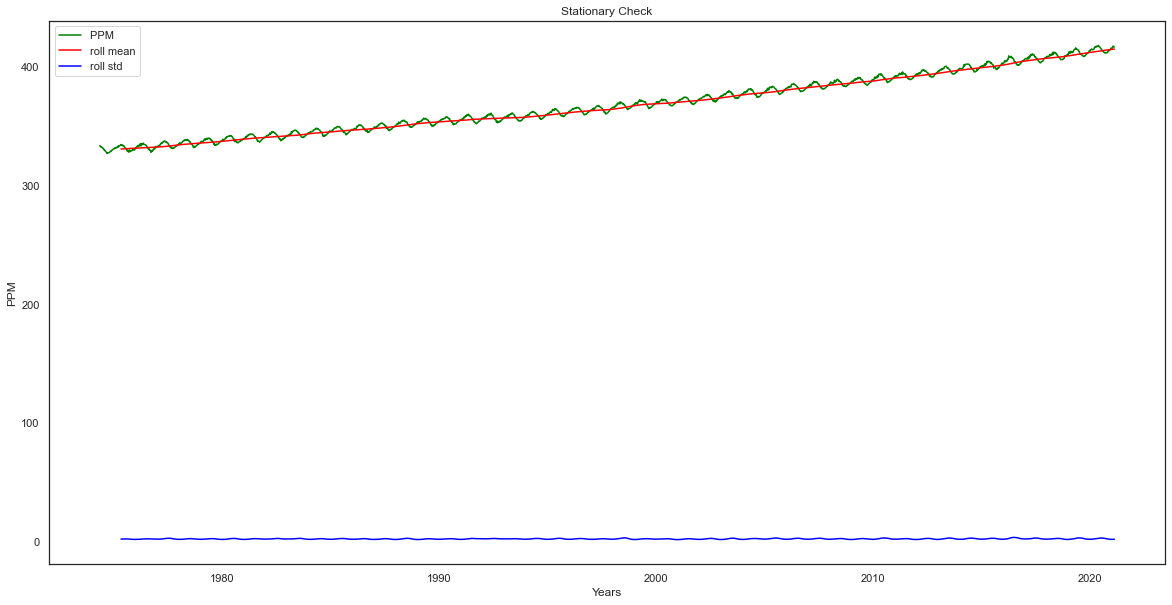

Results of Dickey-Fuller Test: 

Test Statistic                    0.265961
p-value                           0.975728
#Lags Used                       27.000000
Number of Observations Used    2413.000000
Critical Value (1%)              -3.433063
Critical Value (5%)              -2.862739
Critical Value (10%)             -2.567408
dtype: float64


In [37]:
stats_check(avg_week, 52, 'average')

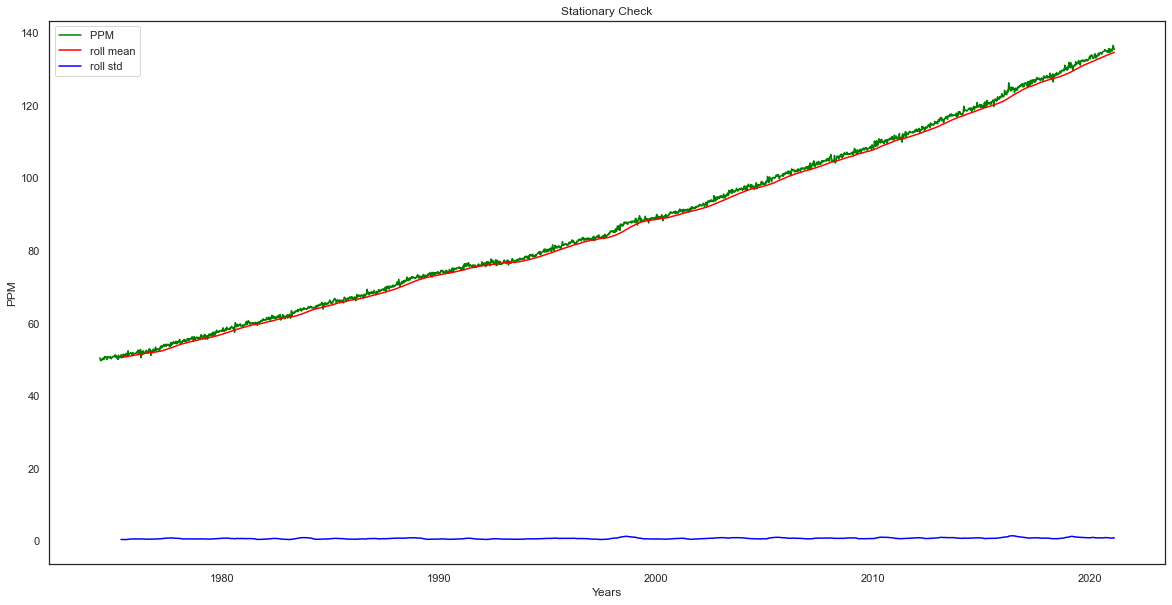

Results of Dickey-Fuller Test: 

Test Statistic                    4.289140
p-value                           1.000000
#Lags Used                       15.000000
Number of Observations Used    2425.000000
Critical Value (1%)              -3.433049
Critical Value (5%)              -2.862733
Critical Value (10%)             -2.567405
dtype: float64


In [38]:
stats_check(inc_week, 52, 'increase since 1800')

,average
Date,
1974-05-19,333.37
1974-05-26,332.95
1974-06-02,332.35
1974-06-09,332.20
1974-06-16,332.37
...,...
2021-01-24,416.01
2021-01-31,417.12
2021-02-07,416.92


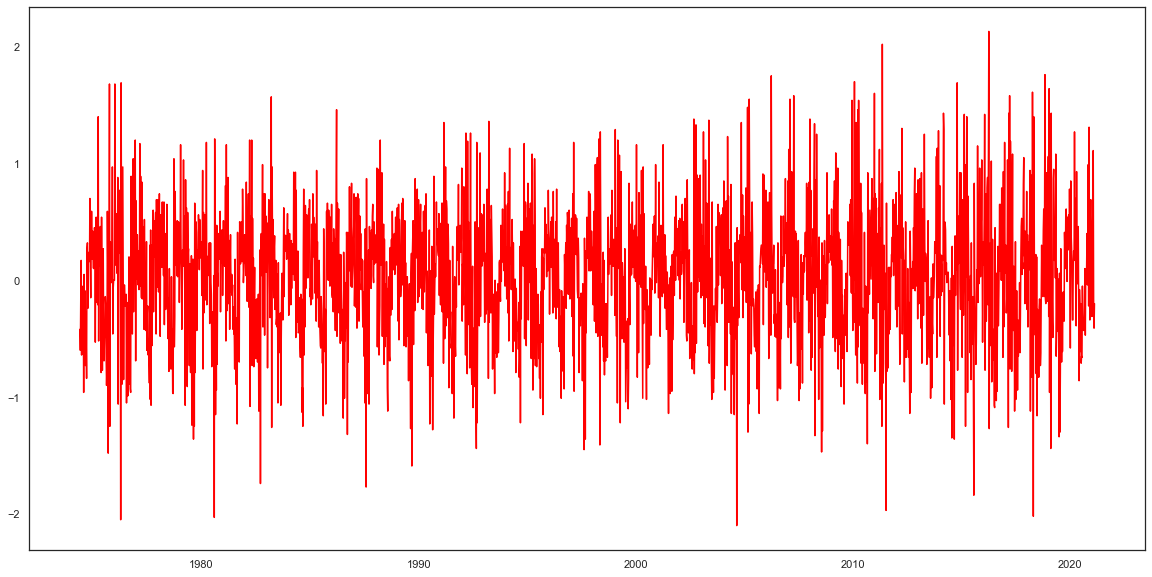

In [39]:
avg_week_diff = avg_week.diff(1)
fig = plt.figure(figsize = (20,10))
plt.plot(avg_week_diff, color='red');

In [40]:
avg_week_diff.dropna(inplace = True)

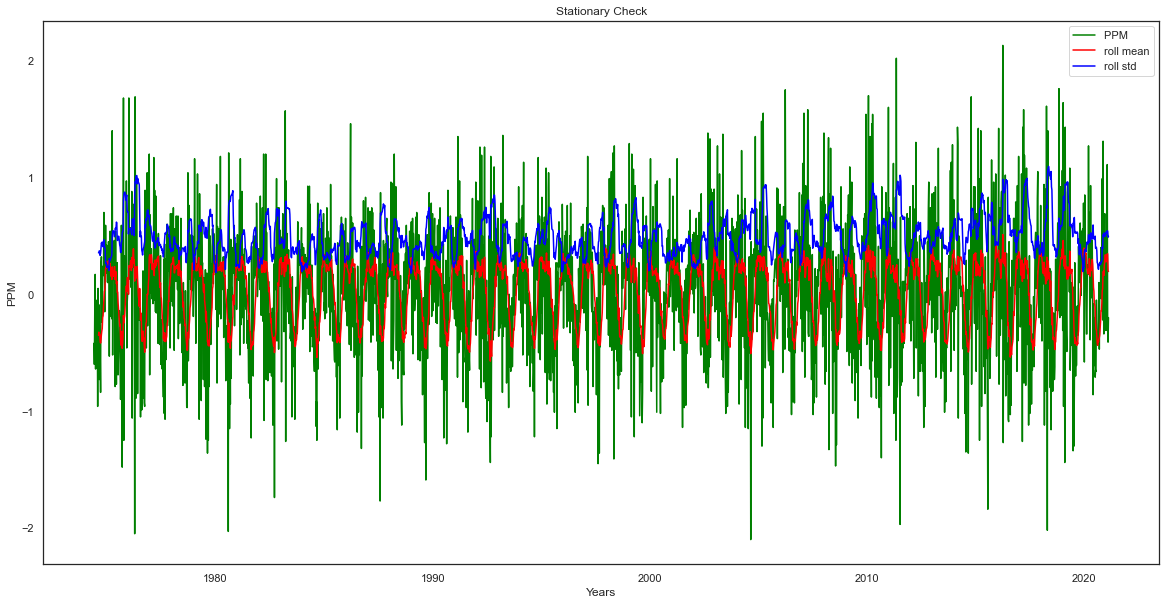

Results of Dickey-Fuller Test: 

Test Statistic                -1.592743e+01
p-value                        7.798566e-29
#Lags Used                     2.700000e+01
Number of Observations Used    2.412000e+03
Critical Value (1%)           -3.433064e+00
Critical Value (5%)           -2.862739e+00
Critical Value (10%)          -2.567408e+00
dtype: float64


In [41]:
stats_check(avg_week_diff, 12, 'average')

In [42]:
# stats_check(avg_week_log, 52, 'average')

In [43]:
# avg_week_sqrt = np.sqrt(avg_week)
# fig = plt.figure(figsize = (20,10))
# plt.plot(avg_week_sqrt, color='red');

In [44]:
# roll_mean_4= avg_week_log.rolling(window=4).mean()
# # roll_mean_12 = avg_week_log.rolling(window=12).mean()
# # roll_mean_52 = avg_week_log.rolling(window=52).mean()
# fig = plt.figure(figsize=(11,7)) 
# plt.plot(avg_week_log, color='red', label = 'log')
# plt.plot(roll_mean_4, color = 'blue', label = 'roll mean 4')
# # plt.plot(roll_mean_12, color = 'orange', label = 'roll mean 16')
# # plt.plot(roll_mean_52, color = 'yellow', label = 'roll mean 52')
# plt.legend(loc='best')
# plt.title('Log Transformed Data with Rolling Mean')
# plt.show()

In [45]:
# # Calculate Weighted Moving Average of log transformed data
# exp_roll_mean_4 = avg_week_log.ewm(halflife = 4).mean()
# # exp_roll_mean_12 = avg_week_log.ewm(halflife = 12).mean()
# # exp_roll_mean_52 = avg_week_log.ewm(halflife = 52).mean()

# # Plot the original data with exp weighted average
# fig = plt.figure(figsize=(12,7))
# plt.plot(avg_week_log, color='blue',label='Original (Log Transformed)')
# plt.plot(exp_roll_mean_4, color='red', label='Exponentially Weighted Rolling Mean 4')
# # plt.plot(exp_roll_mean_12, color='green', label='Exponentially Weighted Rolling Mean 16')
# # plt.plot(exp_roll_mean_52, color='black', label='Exponentially Weighted Rolling Mean 52')
# plt.legend(loc='best')
# plt.show(block=False)

In [46]:
# df_minus_exp_roll_mean_4 = exp_roll_mean_4 - avg_week_log
# df_minus_exp_roll_mean_12 = exp_roll_mean_12 - avg_week_log
# df_minus_exp_roll_mean_52 = exp_roll_mean_52 - avg_week_log


In [47]:
# # Plot the time series
# fig = plt.figure(figsize=(12,7))
# plt.plot(df_minus_exp_roll_mean_4, color='red', label='Exponentially Weighted Rolling Mean 4')
# # plt.plot(df_minus_exp_roll_mean_12, color='green', label='Exponentially Weighted Rolling Mean 12')
# #plt.plot(df_minus_exp_roll_mean_52, color='blue', label='Exponentially Weighted Rolling Mean 52')
# plt.legend(loc='best')
# plt.show(block=False)

In [48]:
# stats_check(df_minus_exp_roll_mean_4, 52, 'average')
# stats_check(df_minus_exp_roll_mean_12, 52, 'average')
# stats_check(df_minus_exp_roll_mean_52, 52, 'average')

In [49]:
# plot_acf(df_minus_exp_roll_mean_4.average[:-1], alpha =0.001);
# plot_acf(df_minus_exp_roll_mean_16.average[:-1], alpha =0.001);
# plot_acf(df_minus_exp_roll_mean_26.average[:-1], alpha =0.001);
# plot_acf(df_minus_exp_roll_mean_52.average[:-1], alpha =0.001);

In [50]:
# plot_pacf(df_minus_exp_roll_mean_4.average[:-1], alpha=0.05, lags = 54);
# plot_pacf(df_minus_exp_roll_mean_16.average[:-1], alpha=0.05, lags = 54);
# plot_pacf(df_minus_exp_roll_mean_26.average[:-1], alpha=0.05, lags = 54);
# plot_pacf(df_minus_exp_roll_mean_52.average[:-1], alpha=0.05, lags = 54);

In [51]:
# diff_avg_week = df_minus_exp_roll_mean_4.diff(periods=12)
# diff_avg_week_16 = df_minus_exp_roll_mean_16.diff(periods=12)
# diff_avg_week_26 = df_minus_exp_roll_mean_26.diff(periods=12)
# diff_avg_week_52 = df_minus_exp_roll_mean_52.diff(periods=12)

In [52]:
# diff_avg_week.dropna(inplace=True)
# diff_avg_week_16.dropna(inplace=True)
# diff_avg_week_26.dropna(inplace=True)
# diff_avg_week_52.dropna(inplace=True)

In [53]:
# fig = plt.figure(figsize=(11,7))
# plt.plot(diff_avg_week, color='green',label='PPM - rolling mean')
# # plt.plot(diff_avg_week_16, color='red',label='PPM - rolling mean')
# # plt.plot(diff_avg_week_26, color='yellow',label='PPM - rolling mean')
# # plt.plot(diff_avg_week_52, color='blue',label='PPM - rolling mean')
# plt.legend(loc='best')
# plt.title('Differenced ppm series')
# plt.show(block=False)

In [54]:
# stats_check(diff_avg_week, 52, 'average');
# stats_check(diff_avg_week_16, 52, 'average');
# stats_check(diff_avg_week_26, 52, 'average');
# stats_check(diff_avg_week_52, 52, 'average');

In [55]:
# plot_acf(avg_week_log.average[:-1], alpha =0.05);
# plot_acf(diff_avg_week_16.average[:-1], alpha =0.001);
# plot_acf(diff_avg_week_26.average[:-1], alpha =0.001);
# plot_acf(diff_avg_week_52.average[:-1], alpha =0.001);

In [56]:
# plot_pacf(avg_week_log.average[:-1], alpha=0.001);
# plot_pacf(diff_avg_week_16.average[:-1], alpha=0.05, lags = 30);
# plot_pacf(diff_avg_week_26.average[:-1], alpha=0.05, lags = 30);
# plot_pacf(diff_avg_week_52.average[:-1], alpha=0.05, lags = 30);

In [59]:
diff_avg_week_train = avg_week_diff.average[:round(len(avg_week_diff) * 0.8)]
diff_avg_week_test = avg_week_diff.average[round(len(avg_week_diff) * 0.8):]
len(diff_avg_week_test)

488

In [204]:
avg_week_train = avg_week.average[:round(len(avg_week) * 0.8)]
avg_week_test = avg_week.average[round(len(avg_week) * 0.8):]
avg_week_train.tail()

Date
2011-09-18    389.29
2011-09-25    388.87
2011-10-02    388.98
2011-10-09    389.01
2011-10-16    389.23
Name: average, dtype: float64

In [ ]:
all_train = avg_week.average[:round(len(avg_week))]
all_test = avg_week.average[round(len(avg_week)):]
len(avg_week_test)

# ARMA!!!!

In [61]:
mod_arma_1 = ARMA(diff_avg_week_train, (3, 1))
res_arma_1 = mod_arma_1.fit(disp=1)
res_arma_1.summary()

/Users/astroraf/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  warnings.warn('No frequency information was'


<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                average   No. Observations:                 1952
Model:                     ARMA(3, 1)   Log Likelihood               -1437.875
Method:                       css-mle   S.D. of innovations              0.505
Date:                Thu, 11 Mar 2021   AIC                           2887.751
Time:                        11:19:49   BIC                           2921.210
Sample:                    05-26-1974   HQIC                          2900.051
                         - 10-16-2011                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0272      0.029      0.940      0.347      -0.030       0.084
ar.L1.average     0.4798      0.035     13.804      0.000       0.412       0.548
ar.L2.average     0.1912      0.024      7.827      0.000       0.143       0.239
ar.L3.average     0.1676      0.025      6.751      0.000       0.119       0.216
ma.L1.average    -0.5899      0.029    -20.666      0.000      -0.646      -0.534
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.1117           -0.0000j            1.1117           -0.0000
AR.2           -1.1261           -2.0244j            2.3165           -0.3308
AR.3           -1.1261           +2.0244j            2.3165            0.3308
MA.1            1.6952           +0.0000j            1.6952            0.0000
-----------------------------------------------------------------------------
"""

In [242]:
mod_arma_2 = ARMA(avg_week, (6, 2))
res_arma_2 = mod_arma_2.fit(disp=1)
pred_arma = res_arma_2.predict(start = '2021-01-31', end = '2030-01-31', dynamic=False)

/Users/astroraf/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  warnings.warn('No frequency information was'
/Users/astroraf/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/Users/astroraf/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [243]:
pred_arma

2021-01-31    415.912998
2021-02-07    416.874430
2021-02-14    417.006955
2021-02-21    416.784795
2021-02-28    416.554432
                 ...    
2030-01-06    419.837325
2030-01-13    419.845700
2030-01-20    419.854072
2030-01-27    419.862443
2030-02-03    419.870813
Freq: W-SUN, Length: 471, dtype: float64

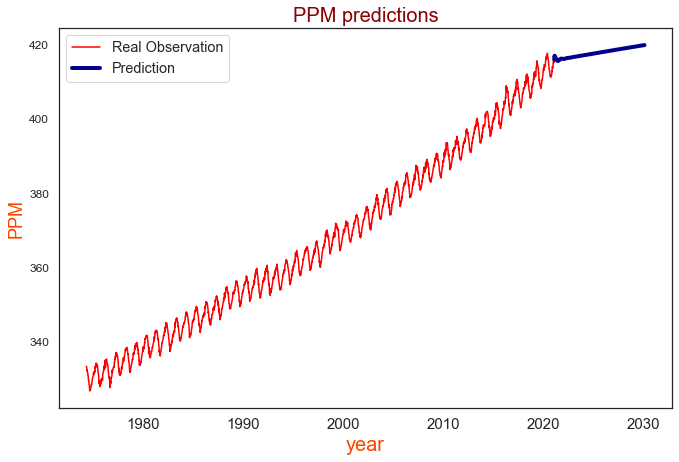

In [244]:
fig, ax = plt.subplots(figsize=(11,7))
ax.plot(avg_week, color='red')
ax.plot(pred_arma, linewidth=4, color='darkblue')
plt.xlabel('year',fontsize=20, color='orangered')
plt.ylabel('PPM', fontsize=18, color='orangered')
plt.xticks(fontsize=15)
plt.yticks(fontsize=12)
plt.title('PPM predictions', fontsize=20, color='darkred')
plt.legend(('Real Observation', 'Prediction'), loc='best', fontsize='x-large')

In [62]:
mod_arma_2 = ARMA(diff_avg_week_train, (6, 2))
res_arma_2 = mod_arma_2.fit(disp=1)
res_arma_2.summary()

/Users/astroraf/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  warnings.warn('No frequency information was'
/Users/astroraf/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                average   No. Observations:                 1952
Model:                     ARMA(6, 2)   Log Likelihood               -1247.931
Method:                       css-mle   S.D. of innovations              0.458
Date:                Thu, 11 Mar 2021   AIC                           2515.862
Time:                        11:20:10   BIC                           2571.628
Sample:                    05-26-1974   HQIC                          2536.364
                         - 10-16-2011                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0317      0.003     11.233      0.000       0.026       0.037
ar.L1.average     1.6654      0.023     72.346      0.000       1.620       1.711
ar.L2.average    -0.4864      0.044    -11.051      0.000      -0.573      -0.400
ar.L3.average    -0.0955      0.045     -2.114      0.035      -0.184      -0.007
ar.L4.average    -0.0234      0.045     -0.518      0.605      -0.112       0.065
ar.L5.average    -0.1510      0.044     -3.439      0.001      -0.237      -0.065
ar.L6.average     0.0708      0.023      3.084      0.002       0.026       0.116
ma.L1.average    -1.9734      0.004   -477.051      0.000      -1.982      -1.965
ma.L2.average     0.9789      0.004    232.691      0.000       0.971       0.987
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            0.9951           -0.1214j            1.0025           -0.0193
AR.2            0.9951           +0.1214j            1.0025            0.0193
AR.3           -1.8000           -0.0000j            1.8000           -0.5000
AR.4           -0.2615           -1.7602j            1.7795           -0.2735
AR.5           -0.2615           +1.7602j            1.7795            0.2735
AR.6            2.4641           -0.0000j            2.4641           -0.0000
MA.1            1.0080           -0.0743j            1.0107           -0.0117
MA.2            1.0080           +0.0743j            1.0107            0.0117
-----------------------------------------------------------------------------
"""

In [65]:
res_arma_1.forecast(488)[0]
res_arma_2.forecast(488)[0]

array([-0.02387922,  0.12532098,  0.15288442,  0.19468966,  0.20800339,
        0.25399813,  0.27967961,  0.30423394,  0.32356963,  0.34124896,
        0.35233857,  0.35916639,  0.36111354,  0.35838184,  0.35067379,
        0.33839763,  0.32167218,  0.30077884,  0.27602206,  0.24781034,
        0.21656351,  0.18275736,  0.14689987,  0.10952987,  0.07120224,
        0.03248489, -0.00605176, -0.04384258, -0.08033647, -0.11500395,
       -0.14734502, -0.17689632, -0.20323777, -0.22599849, -0.24486204,
       -0.25957078, -0.26992935, -0.27580725, -0.27714039, -0.27393179,
       -0.2662511 , -0.25423332, -0.23807645, -0.2180383 , -0.1944324 ,
       -0.16762308, -0.13801994, -0.10607155, -0.07225869, -0.03708714,
       -0.00108011,  0.0352295 ,  0.07130701,  0.10662381,  0.14066506,
        0.17293723,  0.20297521,  0.230349  ,  0.25466988,  0.27559585,
        0.29283651,  0.30615697,  0.3153811 ,  0.3203938 ,  0.32114237,
        0.31763698,  0.30995024,  0.29821578,  0.28262602,  0.26

In [66]:
print('MSE:', mean_squared_error(diff_avg_week_test, res_arma_1.forecast(488)[0]))
print('RMSE:', np.sqrt(mean_squared_error(diff_avg_week_test, res_arma_1.forecast(488)[0])))
print('MAE:', mean_absolute_error(diff_avg_week_test, res_arma_1.forecast(488)[0]))
print('AIC:', res_arma_1.aic)

MSE: 0.37654423438972673
RMSE: 0.6136320024165353
MAE: 0.4757543076890842
AIC: 2887.7505455737582


In [67]:
print('MSE:', mean_squared_error(diff_avg_week_test, res_arma_2.forecast(488)[0]))
print('RMSE:', np.sqrt(mean_squared_error(diff_avg_week_test, res_arma_2.forecast(488)[0])))
print('MAE:', mean_absolute_error(diff_avg_week_test, res_arma_2.forecast(488)[0]))
print('AIC:', res_arma_2.aic)

MSE: 0.32772126728131806
RMSE: 0.5724694465919714
MAE: 0.4375967161601622
AIC: 2515.862242834435


In [200]:
avg_week.iloc[488]

average    340.47
Name: 1983-09-25 00:00:00, dtype: float64

In [240]:
undo_diff_1 = (res_arma_1.forecast(488)[0]).cumsum() 
undo_diff_1 += 389.23

In [205]:
undo_diff = (res_arma_2.forecast(488)[0]).cumsum() 
undo_diff += 389.23

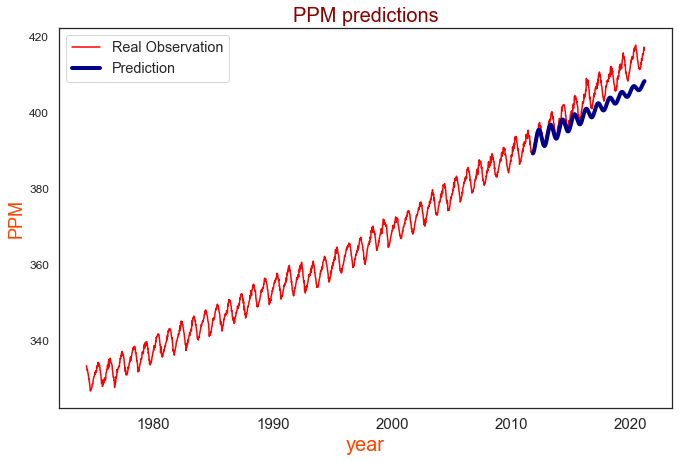

In [206]:
fig, ax = plt.subplots(figsize=(11,7))
ax.plot(avg_week, color='red')
ax.plot(avg_week.iloc[-488:].index, undo_diff, linewidth=4, color='darkblue')
plt.xlabel('year',fontsize=20, color='orangered')
plt.ylabel('PPM', fontsize=18, color='orangered')
plt.xticks(fontsize=15)
plt.yticks(fontsize=12)
plt.title('PPM predictions', fontsize=20, color='darkred')
plt.legend(('Real Observation', 'Prediction'), loc='upper left', fontsize='x-large');

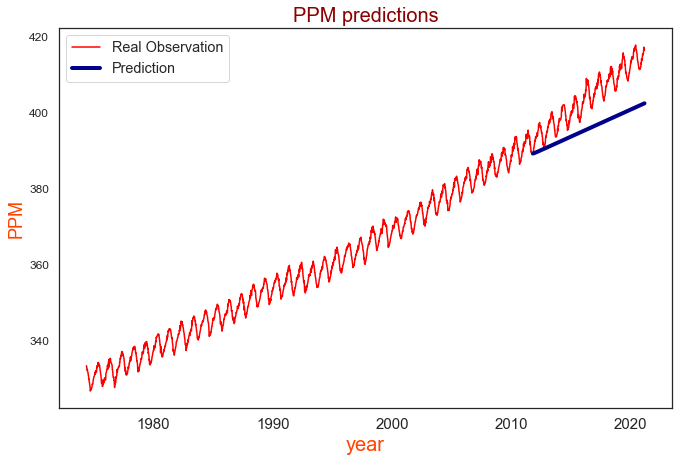

In [241]:
fig, ax = plt.subplots(figsize=(11,7))
ax.plot(avg_week, color='red')
ax.plot(avg_week_diff.iloc[-488:].index, undo_diff_1, linewidth=4, color='darkblue')
plt.xlabel('year',fontsize=20, color='orangered')
plt.ylabel('PPM', fontsize=18, color='orangered')
plt.xticks(fontsize=15)
plt.yticks(fontsize=12)
plt.title('PPM predictions', fontsize=20, color='darkred')
plt.legend(('Real Observation', 'Prediction'), loc='upper left', fontsize='x-large');

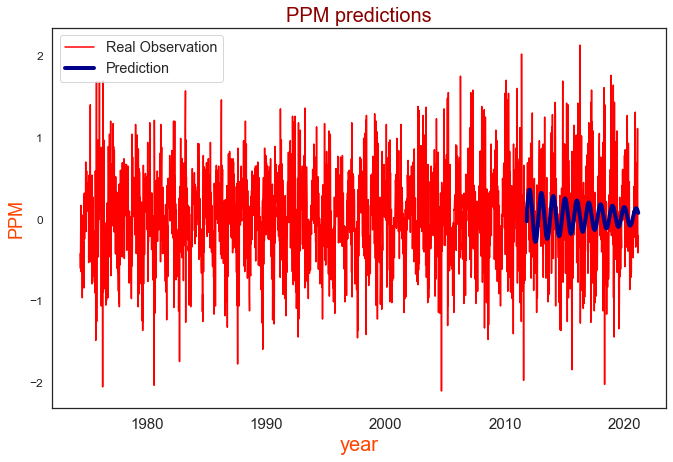

In [70]:
fig, ax = plt.subplots(figsize=(11,7))
ax.plot(avg_week_diff, color='red')
ax.plot(avg_week_diff.iloc[-488:].index, res_arma_2.forecast(488)[0], linewidth=4, color='darkblue')
plt.xlabel('year',fontsize=20, color='orangered')
plt.ylabel('PPM', fontsize=18, color='orangered')
plt.xticks(fontsize=15)
plt.yticks(fontsize=12)
plt.title('PPM predictions', fontsize=20, color='darkred')
plt.legend(('Real Observation', 'Prediction'), loc='upper left', fontsize='x-large')

In [217]:
avg_week.tail()

,average
Date,
2021-01-24,416.01
2021-01-31,417.12
2021-02-07,416.92
2021-02-14,416.51
2021-02-21,416.31


# ARIMA

In [231]:
all_arima = ARIMA(avg_week, order=(2,1,6))
all_arimafit = all_arima.fit(disp=0)


/Users/astroraf/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  warnings.warn('No frequency information was'
/Users/astroraf/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  warnings.warn('No frequency information was'


In [232]:
avg_week.tail()

,average
Date,
2021-01-24,416.01
2021-01-31,417.12
2021-02-07,416.92
2021-02-14,416.51
2021-02-21,416.31


In [236]:
pred = all_arimafit.predict(start = '2021-01-31', end = '2030-01-31', dynamic=False)


In [237]:
pred = pred.cumsum() + 416.3
pred

2021-01-31    416.164585
2021-02-07    415.866429
2021-02-14    415.958638
2021-02-21    416.287592
2021-02-28    416.623893
                 ...    
2030-01-06    432.239603
2030-01-13    432.273822
2030-01-20    432.308041
2030-01-27    432.342259
2030-02-03    432.376478
Freq: W-SUN, Length: 471, dtype: float64

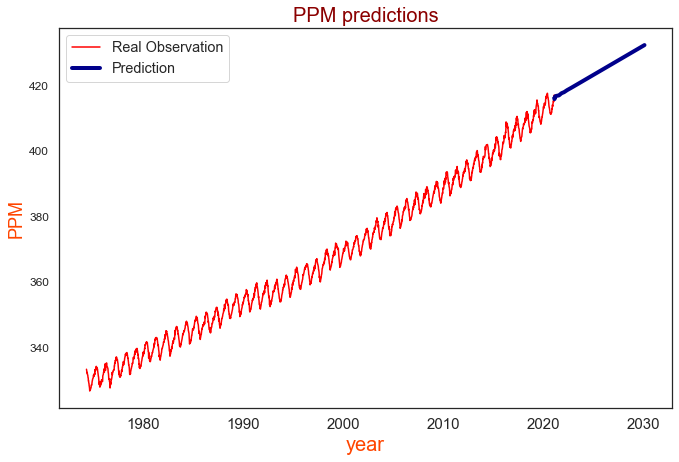

In [238]:
fig, ax = plt.subplots(figsize=(11,7))
ax.plot(avg_week, color='red')
ax.plot(pred, linewidth=4, color='darkblue')
plt.xlabel('year',fontsize=20, color='orangered')
plt.ylabel('PPM', fontsize=18, color='orangered')
plt.xticks(fontsize=15)
plt.yticks(fontsize=12)
plt.title('PPM predictions', fontsize=20, color='darkred')
plt.legend(('Real Observation', 'Prediction'), loc='best', fontsize='x-large')

In [129]:
diff_avg_week_arima = ARIMA(avg_week_train, order=(3,1,0))
diff_avg_week_arimafit = diff_avg_week_arima.fit(disp=1)
diff_avg_week_arimafit.forecast(488)[0]
print('MSE:', mean_squared_error(avg_week_test, diff_avg_week_arimafit.forecast(488)[0]))
print('RMSE:', np.sqrt(mean_squared_error(avg_week_test, diff_avg_week_arimafit.forecast(488)[0])))
print('MAE:', mean_absolute_error(avg_week_test, diff_avg_week_arimafit.forecast(488)[0]))
print('AIC:', diff_avg_week_arimafit.aic)

MSE: 71.9490782270859
RMSE: 8.482280249265871
MAE: 7.695223021619126
AIC: 3010.222478369635


/Users/astroraf/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  warnings.warn('No frequency information was'
/Users/astroraf/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  warnings.warn('No frequency information was'


In [130]:
diff_avg_week_arima = ARIMA(diff_avg_week_train, order=(6,2,0))
diff_avg_week_arimafit_2 = diff_avg_week_arima.fit(disp=1)
diff_avg_week_arimafit_2.forecast(488)[0]
print('MSE:', mean_squared_error(avg_week_test, diff_avg_week_arimafit_2.forecast(488)[0]))
print('RMSE:', np.sqrt(mean_squared_error(avg_week_test, diff_avg_week_arimafit_2.forecast(488)[0])))
print('MAE:', mean_absolute_error(avg_week_test, diff_avg_week_arimafit_2.forecast(488)[0]))
print('AIC:', diff_avg_week_arimafit_2.aic)

/Users/astroraf/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  warnings.warn('No frequency information was'
/Users/astroraf/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  warnings.warn('No frequency information was'


MSE: 152344.72965245243
RMSE: 390.313629857391
MAE: 390.30466902956766
AIC: 3439.6025265491885


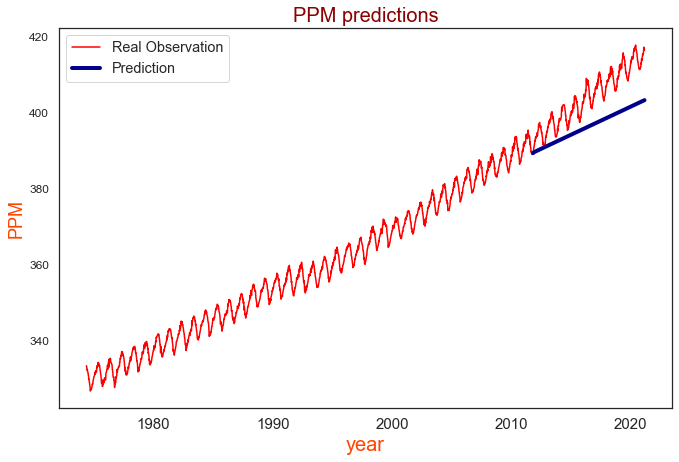

In [132]:
fig, ax = plt.subplots(figsize=(11,7))
ax.plot(avg_week, color='red')
ax.plot(avg_week.iloc[-488:].index, diff_avg_week_arimafit.forecast(488)[0], linewidth=4, color='darkblue')
plt.xlabel('year',fontsize=20, color='orangered')
plt.ylabel('PPM', fontsize=18, color='orangered')
plt.xticks(fontsize=15)
plt.yticks(fontsize=12)
plt.title('PPM predictions', fontsize=20, color='darkred')
plt.legend(('Real Observation', 'Prediction'), loc='upper left', fontsize='x-large')

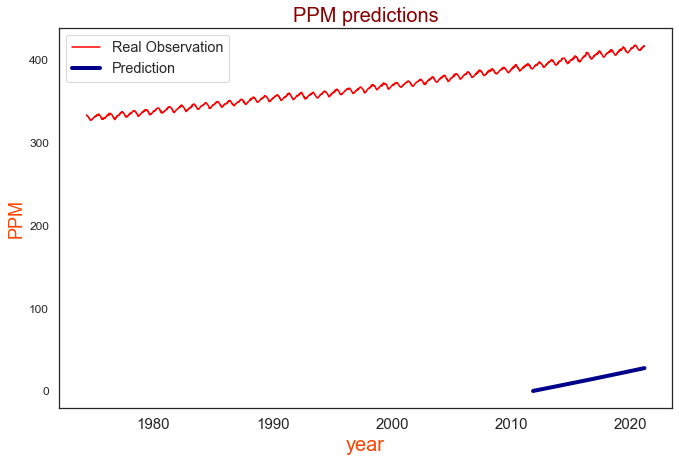

In [133]:
fig, ax = plt.subplots(figsize=(11,7))
ax.plot(avg_week, color='red')
ax.plot(avg_week.iloc[-488:].index, diff_avg_week_arimafit_2.forecast(488)[0], linewidth=4, color='darkblue')
plt.xlabel('year',fontsize=20, color='orangered')
plt.ylabel('PPM', fontsize=18, color='orangered')
plt.xticks(fontsize=15)
plt.yticks(fontsize=12)
plt.title('PPM predictions', fontsize=20, color='darkred')
plt.legend(('Real Observation', 'Prediction'), loc='upper left', fontsize='x-large')

In [134]:
orderlist = []
aiclist = []
rmselist = []
badlist = []
for p in range(1,3):
    for d in range(1,3):
        for q in range(1,5):
            try: 
                ordernow = (p,d,q)
                arimax_now = ARIMA(avg_week_train, order=ordernow).fit(disp=0)
                orderlist.append(ordernow)
                aiclist.append(arimax_now.aic)
                rmselist.append(np.sqrt(mean_squared_error(avg_week_test, arimax_now.forecast(488)[0])))
            except: 
                badlist.append(ordernow)
                continue

/Users/astroraf/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  warnings.warn('No frequency information was'
/Users/astroraf/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  warnings.warn('No frequency information was'
/Users/astroraf/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  warnings.warn('No frequency information was'
/Users/astroraf/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  warnings.warn('No frequency information was'
/Users/astroraf/opt/anaconda3/lib/python3.8/

In [135]:
df_arima = pd.DataFrame()
df_arima['order'], df_arima['aic'], df_arima['rmse'] = orderlist, aiclist, rmselist
df_arima.sort_values('aic')

,order,aic,rmse
11,"(2, 1, 4)",2593.245051,5.234144
10,"(2, 1, 3)",2720.235249,6.838983
9,"(2, 1, 2)",2763.197917,7.502825
3,"(1, 1, 4)",2785.036904,8.245834
2,"(1, 1, 3)",2806.596312,8.478809
1,"(1, 1, 2)",2855.332958,8.813097
5,"(1, 2, 2)",2896.503738,43.591968
13,"(2, 2, 2)",2898.368480,45.979611
6,"(1, 2, 3)",2898.385148,45.729596
14,"(2, 2, 3)",2898.922716,45.477007


In [136]:
best_arima_1 = ARIMA(avg_week_train, order=(2,1,4))
best_arima_1 = best_arima_1.fit(disp=1)
best_arima_1.forecast(488)[0]
print('MSE:', mean_squared_error(avg_week_test, best_arima_1.forecast(488)[0]))
print('RMSE:', np.sqrt(mean_squared_error(avg_week_test, best_arima_1.forecast(488)[0])))
print('MAE:', mean_absolute_error(avg_week_test, best_arima_1.forecast(488)[0]))
print('AIC:', best_arima_1.aic)

/Users/astroraf/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  warnings.warn('No frequency information was'
/Users/astroraf/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  warnings.warn('No frequency information was'


MSE: 27.39626517519168
RMSE: 5.234144168361403
MAE: 4.360741244743161
AIC: 2593.2450513169038


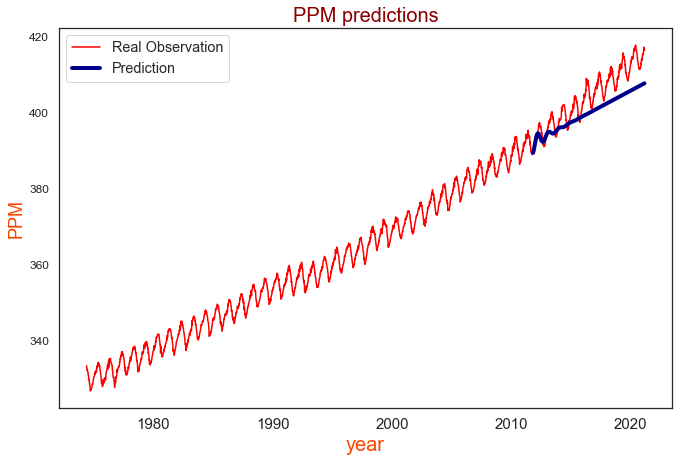

In [138]:
fig, ax = plt.subplots(figsize=(11,7))
ax.plot(avg_week, color='red')
ax.plot(avg_week.iloc[-488:].index, best_arima_1.forecast(488)[0], linewidth=4, color='darkblue')
plt.xlabel('year',fontsize=20, color='orangered')
plt.ylabel('PPM', fontsize=18, color='orangered')
plt.xticks(fontsize=15)
plt.yticks(fontsize=12)
plt.title('PPM predictions', fontsize=20, color='darkred')
plt.legend(('Real Observation', 'Prediction'), loc='upper left', fontsize='x-large')

In [139]:
orderlist = []
mselist = []
rmselist = []
maelist = []
for p in range(1,5):
    for d in range(1,3):
        for q in range(1,7):
            try:
                ordernow = (p,d,q)
                m_arima_now = ARIMA(avg_week_train, order=ordernow).fit()
                orderlist.append(ordernow)
                maelist.append(mean_absolute_error(avg_week_test, m_arima_now.forecast(488)[0]))
                rmselist.append(np.sqrt(mean_squared_error(avg_week_test, m_arima_now.forecast(488)[0])))
                mselist.append(mean_squared_error(avg_week_test, m_arima_now.forecast(488)[0]))
            except: 
                badlist.append(ordernow)
                continue

/Users/astroraf/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  warnings.warn('No frequency information was'
/Users/astroraf/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  warnings.warn('No frequency information was'
/Users/astroraf/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  warnings.warn('No frequency information was'
/Users/astroraf/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  warnings.warn('No frequency information was'
/Users/astroraf/opt/anaconda3/lib/python3.8/

In [142]:
df_arima = pd.DataFrame()
df_arima['order'], df_arima['mse'], df_arima['rmse'], df_arima['mae'] = orderlist, mselist, rmselist, maelist

In [143]:
df_arima.sort_values('rmse').head()

,order,mse,rmse,mae
15,"(2, 1, 6)",26.048820,5.103804,4.297635
13,"(2, 1, 4)",27.396265,5.234144,4.360741
37,"(4, 1, 6)",27.770888,5.269809,4.405215
26,"(3, 1, 5)",27.771654,5.269882,4.405353
27,"(3, 1, 6)",27.828143,5.275239,4.411816


In [144]:
best_arima_2 = ARIMA(avg_week_train, order=(2,1,6))
best_arima_2 = best_arima_2.fit(disp=1)
best_arima_2.forecast(488)[0]
print('MSE:', mean_squared_error(avg_week_test, best_arima_2.forecast(488)[0]))
print('RMSE:', np.sqrt(mean_squared_error(avg_week_test, best_arima_2.forecast(488)[0])))
print('MAE:', mean_absolute_error(avg_week_test, best_arima_2.forecast(488)[0]))
print('AIC:', best_arima_2.aic)

/Users/astroraf/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  warnings.warn('No frequency information was'
/Users/astroraf/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  warnings.warn('No frequency information was'


MSE: 26.048819513210628
RMSE: 5.103804415650215
MAE: 4.297635147338648
AIC: 2495.6575562854923


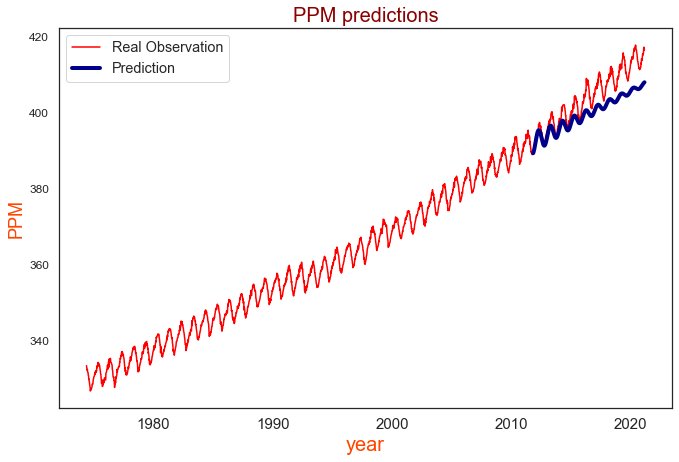

In [145]:
fig, ax = plt.subplots(figsize=(11,7))
ax.plot(avg_week, color='red')
ax.plot(avg_week.iloc[-488:].index, best_arima_2.forecast(488)[0], linewidth=4, color='darkblue')
plt.xlabel('year',fontsize=20, color='orangered')
plt.ylabel('PPM', fontsize=18, color='orangered')
plt.xticks(fontsize=15)
plt.yticks(fontsize=12)
plt.title('PPM predictions', fontsize=20, color='darkred')
plt.legend(('Real Observation', 'Prediction'), loc='upper left', fontsize='x-large')

# SARIMAX

In [146]:
diff_avg_sarimax_1 = sm.tsa.statespace.SARIMAX(endog = avg_week_train, order=(3,1,0))
diff_avg_sarimaxfit_1 = diff_avg_sarimax_1.fit()

/Users/astroraf/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  warnings.warn('No frequency information was'
/Users/astroraf/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  warnings.warn('No frequency information was'


In [147]:
diff_avg_sarimax_2 = sm.tsa.statespace.SARIMAX(endog = avg_week_train, order=(6,2,0))
diff_avg_sarimaxfit_2 = diff_avg_sarimax_2.fit()

/Users/astroraf/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  warnings.warn('No frequency information was'
/Users/astroraf/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  warnings.warn('No frequency information was'


In [148]:
diff_avg_sarimaxfit_1.forecast(488)
diff_avg_sarimaxfit_2.forecast(488)

2011-10-23    389.089612
2011-10-30    389.079891
2011-11-06    389.094616
2011-11-13    389.120130
2011-11-20    389.134654
                 ...    
2021-01-24    392.781161
2021-01-31    392.788793
2021-02-07    392.796425
2021-02-14    392.804057
2021-02-21    392.811689
Freq: W-SUN, Name: predicted_mean, Length: 488, dtype: float64

In [149]:
print('MSE:', mean_squared_error(avg_week_test, diff_avg_sarimaxfit_1.forecast(488)))
print('RMSE:', np.sqrt(mean_squared_error(avg_week_test, diff_avg_sarimaxfit_1.forecast(488))))
print('MAE:', mean_absolute_error(avg_week_test, diff_avg_sarimaxfit_1.forecast(488)))

MSE: 262.47292006147694
RMSE: 16.201016019419182
MAE: 14.56773929674344


In [150]:
print('MSE:', mean_squared_error(avg_week_test, diff_avg_sarimaxfit_2.forecast(488)))
print('RMSE:', np.sqrt(mean_squared_error(avg_week_test, diff_avg_sarimaxfit_2.forecast(488))))
print('MAE:', mean_absolute_error(avg_week_test, diff_avg_sarimaxfit_2.forecast(488)))


MSE: 207.00828690290567
RMSE: 14.387782556839872
MAE: 13.037544438149784


In [151]:
m_auto = pm.auto_arima(avg_week_train, start_p=1, start_d=1, start_q=1, max_p=10, max_d=5, max_q=10,
                             seasonal = False,
                             d=None, D=None, trace=True,
                             error_action='ignore',  # don't want to know if an order does not work
                             suppress_warnings=True,  # don't want convergence warnings
                             stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=3049.298, Time=1.30 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=3175.762, Time=0.18 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=3177.662, Time=0.14 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3177.690, Time=0.17 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=3179.132, Time=0.06 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=2927.758, Time=0.71 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=3103.435, Time=0.18 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=2887.751, Time=0.67 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=3010.223, Time=0.37 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=2855.512, Time=0.70 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=2901.393, Time=0.34 sec
 ARIMA(5,1,1)(0,0,0)[0] intercept   : AIC=2847.777, Time=0.88 sec
 ARIMA(5,1,0)(0,0,0)[0] intercept   : AIC=2852.008, Time=0.44 sec
 ARIMA(6,1,1)(0,0,0)[0] intercept   : AIC=2848.129, Time=1.08 sec
 ARIMA(5,1,2)(0,0,0)[0] intercept

In [104]:
m_auto.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 1952
Model:               SARIMAX(5, 0, 2)   Log Likelihood               -1348.542
Date:                Thu, 11 Mar 2021   AIC                           2715.084
Time:                        11:36:39   BIC                           2765.273
Sample:                             0   HQIC                          2733.535
                               - 1952                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0019      0.001      1.545      0.122      -0.001       0.004
ar.L1          1.5241      0.027     56.109      0.000       1.471       1.577
ar.L2         -0.4566      0.039    -11.666      0.000      -0.533      -0.380
ar.L3         -0.0662      0.039     -1.682      0.092      -0.143       0.011
ar.L4          0.0147      0.039      0.374      0.708      -0.062       0.091
ar.L5         -0.0807      0.026     -3.154      0.002      -0.131      -0.031
ma.L1         -1.7260      0.020    -84.606      0.000      -1.766      -1.686
ma.L2          0.8373      0.020     40.987      0.000       0.797       0.877
sigma2         0.2330      0.006     36.672      0.000       0.221       0.245
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                67.65
Prob(Q):                              0.98   Prob(JB):                         0.00
Heteroskedasticity (H):               1.15   Skew:                             0.08
Prob(H) (two-sided):                  0.08   Kurtosis:                         3.90
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [152]:
diff_avg_week_arima = ARIMA(avg_week_train, order=(5,1,2))
diff_avg_week_arimafit_3 = diff_avg_week_arima.fit(disp=1)
print('MSE:', mean_squared_error(avg_week_test, diff_avg_week_arimafit_3 .forecast(488)[0]))
print('RMSE:', np.sqrt(mean_squared_error(avg_week_test, diff_avg_week_arimafit_3 .forecast(488)[0])))
print('MAE:', mean_absolute_error(avg_week_test, diff_avg_week_arimafit_3.forecast(488)[0]))
print('AIC:', diff_avg_week_arimafit_3.aic)

/Users/astroraf/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  warnings.warn('No frequency information was'
/Users/astroraf/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  warnings.warn('No frequency information was'


MSE: 46.42202138951717
RMSE: 6.813370780275881
MAE: 5.939148692625728
AIC: 2715.077258450022


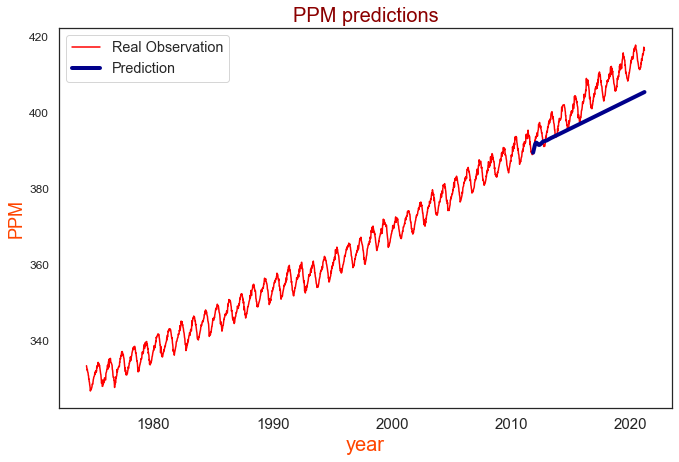

In [153]:
fig, ax = plt.subplots(figsize=(11,7))
ax.plot(avg_week, color='red')
ax.plot(avg_week.iloc[-488:].index, diff_avg_week_arimafit_3.forecast(488)[0], linewidth=4, color='darkblue')
plt.xlabel('year',fontsize=20, color='orangered')
plt.ylabel('PPM', fontsize=18, color='orangered')
plt.xticks(fontsize=15)
plt.yticks(fontsize=12)
plt.title('PPM predictions', fontsize=20, color='darkred')
plt.legend(('Real Observation', 'Prediction'), loc='upper left', fontsize='x-large')

In [154]:
weekly_auto_foca = m_auto.predict(488)

In [248]:
print('MSE:', mean_squared_error(avg_week_test, weekly_auto_foca))
print('RMSE:', np.sqrt(mean_squared_error(avg_week_test, weekly_auto_foca)))
print('MAE:', mean_absolute_error(avg_week_test, weekly_auto_foca))
print('AIC:', weekly_auto_foca.aic)

MSE: 222.04703492769656
RMSE: 14.901242730983768
MAE: 13.107045469296075


AttributeError: 'numpy.ndarray' object has no attribute 'aic'

In [156]:
orderlist = []
mselist = []
rmselist = []
maelist = []
for p in range(1,7):
    for d in range(1,3):
        for q in range(1,7):
            ordernow = (p,d,q)
            m_sarimax_now = sm.tsa.statespace.SARIMAX(endog = avg_week_train, order=ordernow).fit()
            orderlist.append(ordernow)
            maelist.append(mean_absolute_error(avg_week_test, m_sarimax_now.forecast(488)))
            rmselist.append(np.sqrt(mean_squared_error(avg_week_test, m_sarimax_now.forecast(488))))
            mselist.append(mean_squared_error(avg_week_test, m_sarimax_now.forecast(488)))

/Users/astroraf/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  warnings.warn('No frequency information was'
/Users/astroraf/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  warnings.warn('No frequency information was'
/Users/astroraf/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  warnings.warn('No frequency information was'
/Users/astroraf/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  warnings.warn('No frequency information was'
/Users/astroraf/opt/anaconda3/lib/python3.8/

In [157]:
df_sarimax_best = pd.DataFrame()
df_sarimax_best['order'], df_sarimax_best['mse'], df_sarimax_best['rmse'], df_sarimax_best['mae'] = orderlist, mselist, rmselist, maelist

In [158]:
df_sarimax_best.sort_values('rmse').head()

,order,mse,rmse,mae
71,"(6, 2, 6)",121.309562,11.014062,9.638010
44,"(4, 2, 3)",140.384323,11.848389,10.443946
59,"(5, 2, 6)",159.907887,12.645469,11.174608
54,"(5, 2, 1)",197.129404,14.040278,12.729518
29,"(3, 1, 6)",208.070328,14.424643,12.566300


In [159]:
arimax_co2_best = sm.tsa.statespace.SARIMAX(endog = avg_week_train, order=(6,2,6))
arimax_co2_best = arimax_co2_best.fit()

/Users/astroraf/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  warnings.warn('No frequency information was'
/Users/astroraf/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  warnings.warn('No frequency information was'
/Users/astroraf/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [247]:
print('MSE:', mean_squared_error(avg_week_test, arimax_co2_best.forecast(488)))
print('RMSE:', np.sqrt(mean_squared_error(avg_week_test, arimax_co2_best.forecast(488))))
print('MAE:', mean_absolute_error(avg_week_test, arimax_co2_best.forecast(488)))
print('AIC:', arimax_co2_best.aic)

MSE: 121.30956150674346
RMSE: 11.014061989418048
MAE: 9.638009763616916
AIC: 2806.3782011688363


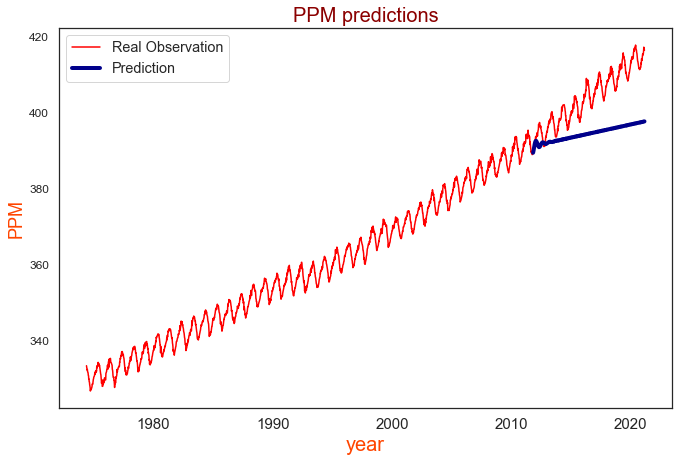

In [161]:
fig, ax = plt.subplots(figsize=(11,7))
ax.plot(avg_week, color='red')
ax.plot(avg_week.iloc[-488:].index, arimax_co2_best.forecast(488), linewidth=4, color='darkblue')
plt.xlabel('year',fontsize=20, color='orangered')
plt.ylabel('PPM', fontsize=18, color='orangered')
plt.xticks(fontsize=15)
plt.yticks(fontsize=12)
plt.title('PPM predictions', fontsize=20, color='darkred')
plt.legend(('Real Observation', 'Prediction'), loc='upper left', fontsize='x-large')